In [7]:
try:
    import arviz as az
    import pymc as pm
except ModuleNotFound:
    !sudo /bin/bash -c "(source /venv/bin/activate; pip install pymc)"
    !sudo /bin/bash -c "(source /venv/bin/activate; pip install arviz)"
    #!pip install arviz
    #!pip install pymc3
    pass

In [32]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install graphviz)"

     |████████████████████████████████| 47 kB 4.0 MB/s eta 0:00:01


In [33]:
import numpy as np

print("numpy version=", np.__version__)
import pymc as pm

print("pymc3 version=", pm.__version__)
import arviz as az

print("arviz version=", az.__version__)
import graphviz

print("graphviz version=", graphviz.__version__)

numpy version= 1.26.0
pymc3 version= 5.10.4
arviz version= 0.17.0
graphviz version= 0.20.1


In [18]:
from IPython.display import HTML, display

# Control the size of the notebook.
display(HTML("<style>.container { width:80% !important; }</style>"))

https://python.arviz.org/en/latest/index.html

- ArviZ is a package for exploratory analysis of Bayesian models.
- It is backend agnostic (e.g., PyStan, PyMC, raw `numpy` arrays)

# Getting Started

https://python.arviz.org/en/latest/getting_started/index.html#

## ArviZ quickstart

https://python.arviz.org/en/latest/getting_started/Introduction.html

[ 0.83843169  1.82348363 -1.39890668 ... -0.13049848 -0.96049099
  0.87608695]


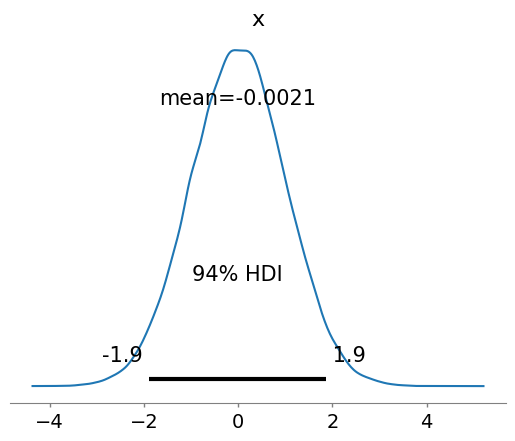

In [20]:
# Plot a distribution with some info about HDI.
vals = np.random.randn(100_000)
print(vals)
az.plot_posterior(vals)

In [22]:
# A 2d array is interpreted as "chain x draws" by `arviz`.
# 10 chains, 50 draws.
size = (10, 50)
# print(np.random.randn(*size))

/venv/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/venv/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/venv/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/venv/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to 

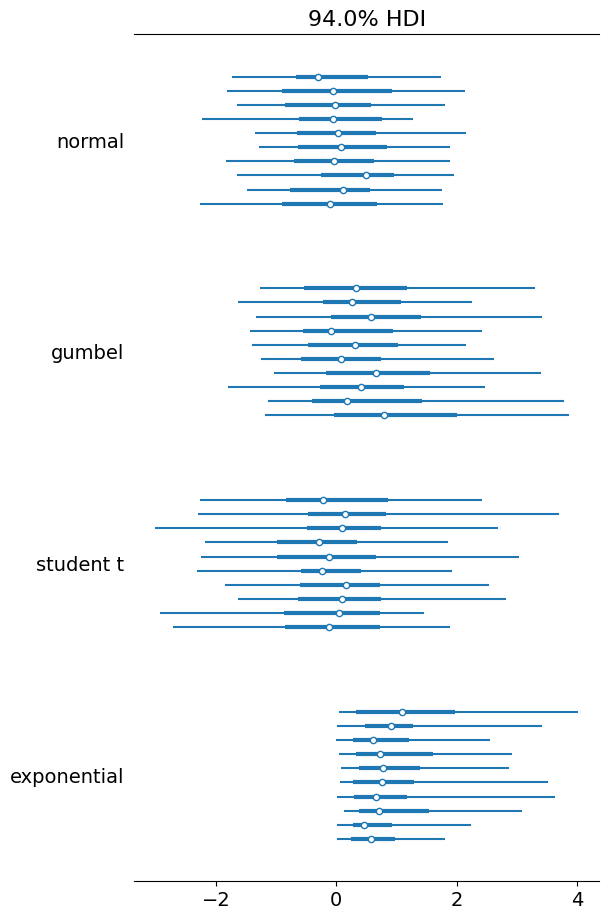

In [23]:
size = (10, 50)
# A dict is interpreted as multiple random vars, each with different "chains x draws".
data = {
    "normal": np.random.randn(*size),
    "gumbel": np.random.gumbel(size=size),
    "student t": np.random.standard_t(df=6, size=size),
    "exponential": np.random.exponential(size=size),
}
az.plot_forest(data)
# So there are 4 RVs, each with 10 realizations, each with 50 samples.

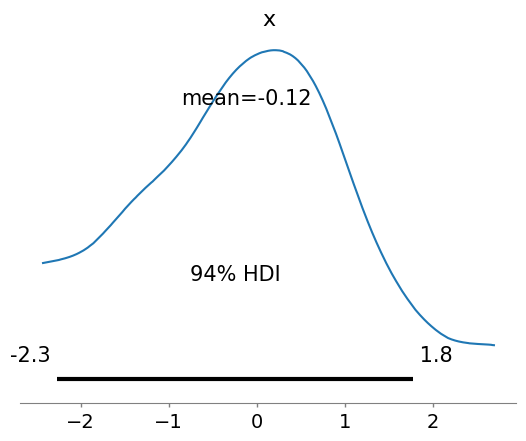

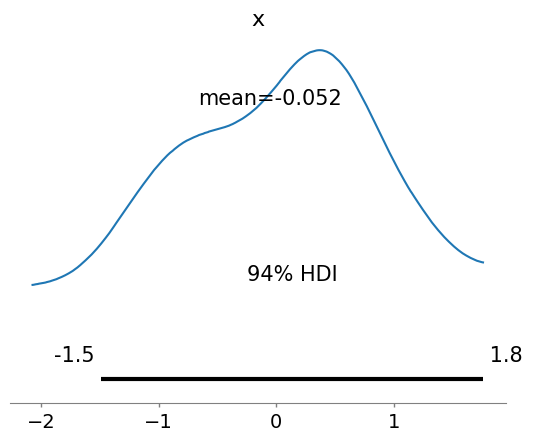

In [28]:
az.plot_posterior(data["normal"][0])
az.plot_posterior(data["normal"][1])

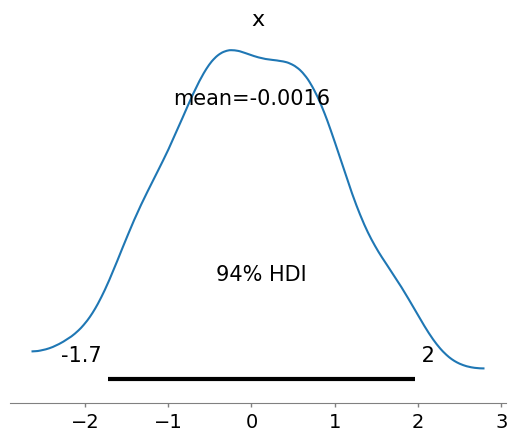

In [26]:
# data["normal"] is a 10 chains x 50 samples, but when plotting all the data is concat.
az.plot_posterior(data["normal"])

## InferenceData

From https://python.arviz.org/en/latest/getting_started/Introduction.html#convert-to-inferencedata

The object returned by most PyMC sampling methods is `arviz.InferenceData`.

In [51]:
# 8 school examples
# - there are 8 schools (each with a name)
# -

J = 8
# Observations.
# - Mean (unknown).
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
# - Std dev (is known).
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

schools = np.array(
    [
        "Choate",
        "Deerfield",
        "Phillips Andover",
        "Phillips Exeter",
        "Hotchkiss",
        "Lawrenceville",
        "St. Paul's",
        "Mt. Hermon",
    ]
)

# with pm.Model() as centered_eight:
#    # 8 normal RVs for the mean.
#    mu = pm.Normal("mu", mu=0, sigma=5)
#    tau = pm.HalfCauchy("tau", beta=5)
#    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)
#    # The observed data has:
#    # - random means and
#    # - known std dev.
#    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
#    # This pattern is useful in PyMC3.
#    #prior = pm.sample_prior_predictive()
#    # Sample the posterior.
#    centered_eight_trace = pm.sample(
#        # Return data as arviz.InferenceData instead of MultiTrace.
#        return_inferencedata=False)
#    posterior_predictive = pm.sample_posterior_predictive(centered_eight_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [obs]


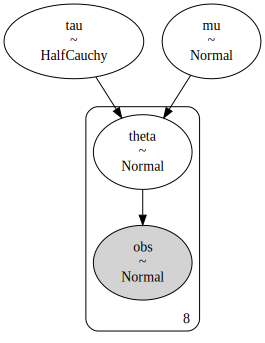

In [34]:
# pm.model_to_graphviz(centered_eight)

- Most ArviZ functions accept `trace` objects.
- It can be converted into `InferenceData`

In [55]:
# print(type(centered_eight))
# print(centered_eight)

# print(type(centered_eight_trace))
# print(centered_eight_trace)

In [54]:
with pm.Model(coords={"school": schools}) as centered_eight:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sigma=tau, dims="school")
    pm.Normal("obs", mu=theta, sigma=sigma, observed=y, dims="school")

    # This pattern can be useful in PyMC
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [mu, obs, tau, theta]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [obs]


In [56]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [36]:
az.plot_autocorr(centered_eight_trace)

ValueError: Can only convert xarray dataarray, xarray dataset, dict, netcdf filename, numpy array, pystan fit, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not MultiTrace

In [38]:
# Build the inference data from PyMC3 run.
data = az.from_pymc(
    trace=centered_eight_trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    model=centered_eight,
    coords={"school": schools},
    dims={"theta": ["school"], "obs": ["school"]},
)
data

AttributeError: module 'arviz' has no attribute 'from_pymc'

## Intro do xarray, InferenceData

From https://python.arviz.org/en/latest/getting_started/XarrayforArviZ.html

Bayesian inference generates numerous datasets:
- Prior / posterior distribution for vars
- Observed data
- Prior / posterior predictive distribution
- Trace data for each of the above
- Sample statistics for each inference run

Data from probabilistic programming is high-dimensional
- Use `xarray` to store high-dimensional data with human readable dimensions and coordinates

In [ ]:
print(az.list_datasets())

In [ ]:
# From Bayesian Data Analysis, section 5.5 (Gelman et al. 2013):

# A study was performed for the Educational Testing Service to analyze the effects of special coaching
# programs for SAT-V (Scholastic Aptitude Test-Verbal) in each of eight high schools. The outcome variable
# in each study was the score on a special administration of the SAT-V, a standardized multiple choice test
# administered by the Educational Testing Service and used to help colleges make admissions decisions; the
# scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT
# examinations are designed to be resistant to short-term efforts directed specifically toward improving
# performance on the test; instead they are designed to reflect knowledge acquired and abilities developed
# over many years of education. Nevertheless, each of the eight schools in this study considered its short-term
# coaching program to be very successful at increasing SAT scores. Also, there was no prior reason to believe
# that any of the eight programs was more effective than any other or that some were more similar in effect to
# each other than to any other.

In [ ]:
data = az.load_arviz_data("centered_eight")
data

- There are 3 variables and 4 chains

In [ ]:
observed_data = data.observed_data
observed_data

- `xarray.Dataset` (and `InferenceData`) store data in memory
- NetCDF is a standard for serializing data

## Creating InferenceData

From https://python.arviz.org/en/latest/getting_started/CreatingInferenceData.html

In [ ]:
size = 100
data = np.random.randn(size)
dataset = az.convert_to_inference_data(data)
dataset

## Working with InferenceData

From https://python.arviz.org/en/latest/getting_started/WorkingWithInferenceData.html

# User guide

## Data structures

### InferenceData schema
https://python.arviz.org/en/latest/schema/schema.html#schema